# Visualizing layout structures in GeM corpora

This Jupyter notebook is intended for visualizing the hierarchical organization of multimodal documents, as proposed in the <a href="http://www.fb10.uni-bremen.de/anglistik/langpro/projects/gem/newframe.html">Genre and Multimodality</a> model.

For visualizing the layout structures, you need a valid XML file for the layout layer.

To do so, the notebook adopts the solution proposed in Hiippala (2013, 2015). The RST relations ("spans") are represented using DOT nodes.

**References**

Hiippala, T. (2013) *Modelling the structure of a multimodal artefact*. PhD thesis, University of
Helsinki. https://helda.helsinki.fi/handle/10138/41736

Hiippala, T. (2015) *The Structure of Multimodal Documents: An Empirical Approach*. New York and London: Routledge.

## 1. Import the necessary packages.

In [21]:
# For parsing XML
from lxml import etree as et

# For formatting the content
import textwrap
import codecs

# For testing
from IPython.display import Image

Check GraphViz installation.

In [22]:
graphviz_installed = !which dot
if graphviz_installed == '':
    print "Graphviz/DOT not found. Exiting ..."
    quit()
else:
    print "\nGraphviz/DOT found ..."


Graphviz/DOT found ...


## 2. Parse the GeM XML file.

Define the layout file below.

In [23]:
layoutfile = 'test_xml/1980-tgh-layout-1.xml' # Layout layer

Define a function to parse the XML files.

In [26]:
def parse_xml(layoutfile):

    layout_root = {} # Set up a dictionary for the layout root
    layout_leafs = {} # Set up a dictionary for the layout leafs
    layout_chunks = {} # Set up a dictionary for the layout chunks
    
    layout_xmlroot = et.parse(layoutfile).getroot()
        
    for root in layout_xmlroot.xpath('.//layout-structure/layout-root'):
        layout_root[root.attrib['id']] = '"' + root.attrib['id'] + '" [fontcolor="black", fontsize="12.0", shape="box"];\n'
    
    for leaf in layout_xmlroot.xpath('.//layout-structure//layout-leaf'):
        leaf_xpath = './/realization/*[contains(@xref, "' + leaf.attrib['xref'] + '")]'
        for leaf_real in layout_xmlroot.xpath('%s' % leaf_xpath):
            if leaf_real.tag == 'graphics':
                layout_leafs[leaf.attrib['xref']] = '"' + leaf.attrib['xref'] + '" [fontcolor="red", fontsize="10.0", shape="box"];\n'
            if leaf_real.tag == 'text':
                layout_leafs[leaf.attrib['xref']] = '"' + leaf.attrib['xref'] + '" [fontcolor="black", fontsize="10.0", shape="box"];\n'
            else:
                continue
        
    for chunk in layout_xmlroot.xpath('.//layout-structure//layout-chunk'):
        layout_chunks[chunk.attrib['id']] = '"' + chunk.attrib['id'] + '" [fontcolor="black", fontsize="10.0", shape="box"];\n'
        
    return layout_xmlroot, layout_root, layout_leafs, layout_chunks

In [27]:
layout_xmlroot, layout_root, layout_leafs, layout_chunks = parse_xml(layoutfile)

## 3. Draw the layout graph.

Open a file for the graph; use UTF-8 encoding. Set up the beginning and the end of the graph.

In [28]:
graph = codecs.open('layout_graph.gv', 'w', 'utf-8')

begin_graph = 'graph "layout_graph" { graph [rankdir="BT"];\n'
terminate_graph = '}\n'

Begin writing the graph.

In [29]:
# Write DOT graph preamble
graph.write(begin_graph)

# Add layout root to the graph:
for root, root_node in layout_root.items():
    graph.write(root_node)

# Add layout leafs and their edges to the graph
for leaf, leaf_nodes in layout_leafs.items():
    graph.write(leaf_nodes)
    leaf_parent_xpath = './/layout-structure//layout-leaf[@xref="' + leaf + '"]/../@id'
    for leaf_parent in layout_xmlroot.xpath('%s' % leaf_parent_xpath):
        l_edge = '"' + leaf + '"' + ' -- ' + '"' + leaf_parent + '";\n'
        graph.write(l_edge)

# Add layout chunks and their edges to the graph
for chunk, chunk_nodes in layout_chunks.items():
    graph.write(chunk_nodes)
    chunk_parent_xpath = './/layout-structure//layout-chunk[@id="' + chunk + '"]/../@id'
    for chunk_parent in layout_xmlroot.xpath('%s' % chunk_parent_xpath):
        c_edge = '"' + chunk + '"' + ' -- ' + '"' + chunk_parent + '";\n'
        graph.write(c_edge)

# Terminate the graph
graph.write(terminate_graph)        

Close the graph file.

In [30]:
graph.close()

Draw the graph using DOT.

In [31]:
!dot -Tpng layout_graph.gv > layout_graph.png

Show the resulting image in the Jupyter notebook.

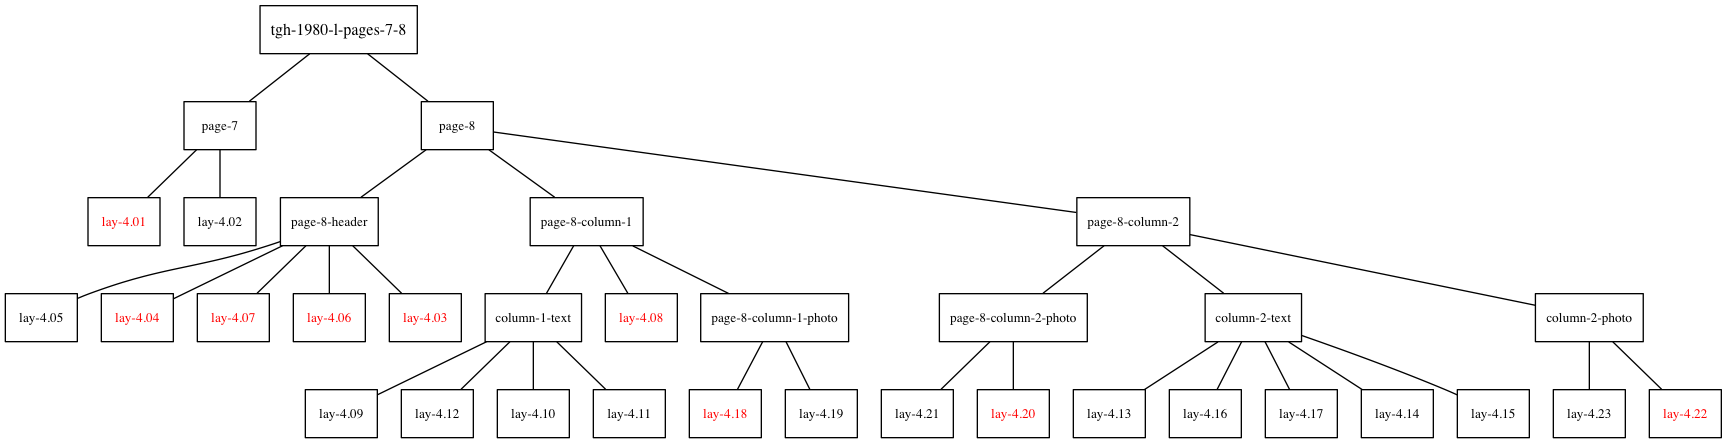

In [32]:
Image('layout_graph.png')